https://www.kaggle.com/code/imsparsh/food-classifier-mobilenetv2-resnet50-vgg16

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# importing libraries
import os
import warnings
warnings.filterwarnings('ignore')

import time

import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
%matplotlib inline
# %load_ext tensorboard
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use('seaborn-deep')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['figure.titlesize'] = 14
plt.rcParams['figure.figsize'] = (12, 8)

pd.options.mode.chained_assignment = None
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 400)

import sklearn.metrics as skm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from skimage.transform import resize
from skimage import img_as_ubyte
from imageio import imread
import datetime

from tqdm import tqdm

import cv2
from google.colab.patches import cv2_imshow


seed = 42

In [4]:
import tensorflow as tf
from tensorflow import keras as k
print(tf.__version__)
from keras import backend as K
import os, shutil, re, string
import matplotlib.pyplot as plt
import spacy
seed=100

2.15.0


In [5]:
def set_seed():
    global seed
    os.environ['PYTHONHASHSEED']=str(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_seed()

In [6]:
csv_path = '/content/drive/MyDrive/project3/data/traindata/read_image.csv'

df = pd.read_csv(csv_path)
df.head()


,file_path,type,middle_class,small_class,food_class,group_number,crop_area
0,/content/drive/MyDrive/project3/data/traindata...,raw,구이,갈비구이,구이/갈비구이,1,NaN
1,/content/drive/MyDrive/project3/data/traindata...,raw,구이,갈비구이,구이/갈비구이,2,NaN
2,/content/drive/MyDrive/project3/data/traindata...,raw,구이,갈비구이,구이/갈비구이,3,NaN
3,/content/drive/MyDrive/project3/data/traindata...,raw,구이,갈비구이,구이/갈비구이,4,NaN
4,/content/drive/MyDrive/project3/data/traindata...,raw,구이,갈비구이,구이/갈비구이,5,NaN


In [7]:
df['file_path'][0]

'/content/drive/MyDrive/project3/data/traindata/raw_image/구이/갈비구이/Img_000_0308.jpg'

In [8]:
df['food_class'].value_counts()

food_class
조림/코다리조림         1123
적/떡꼬치               1095
해물/멍게               1089
볶음/오징어채볶음    1079
해물/산낙지            1065
                          ... 
찜/해물찜               992
구이/삼겹살             990
면/수제비                 988
면/라면                  988
면/물냉면              988
Name: count, Length: 150, dtype: int64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150283 entries, 0 to 150282
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   file_path     150283 non-null  object
 1   type          150283 non-null  object
 2   middle_class  150283 non-null  object
 3   small_class   150283 non-null  object
 4   food_class    150283 non-null  object
 5   group_number  150283 non-null  int64 
 6   crop_area     51353 non-null   object
dtypes: int64(1), object(6)
memory usage: 8.0+ MB


In [ ]:
df2 = df[((df['small_class'] == '갈비구이' ) | (df['small_class'] == '비빔밥') | (df['small_class'] == '떡꼬치')) & (df['type'] == 'crop')]
df2.reset_index(drop=True, inplace=True)
df2.head()

,file_path,type,middle_class,small_class,food_class,group_number
0,/content/drive/MyDrive/project3/data/traindata...,crop,구이,갈비구이,구이/갈비구이,75
1,/content/drive/MyDrive/project3/data/traindata...,crop,구이,갈비구이,구이/갈비구이,78
2,/content/drive/MyDrive/project3/data/traindata...,crop,구이,갈비구이,구이/갈비구이,79
3,/content/drive/MyDrive/project3/data/traindata...,crop,구이,갈비구이,구이/갈비구이,80
4,/content/drive/MyDrive/project3/data/traindata...,crop,구이,갈비구이,구이/갈비구이,81


In [ ]:
# 모든 이미지를 동일한 크기로 리사이즈하기 위해 크기 설정
# VGG_size (224, 224)
# 정사격형으로 먼저 만들고
# 이 사이즈보다 작은 경우 white space를 넣어서 224*224 사이즈로

def make_square(image):
    old_size = image.shape[:2]  # 현재 이미지의 크기
    square_size = max(old_size)  # 가장 긴 변을 기준으로 정사각형 크기 설정

    # 흰색 배경의 정사각형 이미지를 생성하고 중앙에 원본 이미지를 배치
    new_image = np.ones((square_size, square_size, 3), dtype=np.uint8) * 255  # 흰색 배경
    top_left = ((square_size - old_size[0]) // 2, (square_size - old_size[1]) // 2)
    new_image[top_left[0]:top_left[0] + old_size[0], top_left[1]:top_left[1] + old_size[1]] = image

    return new_image

def resize_with_whitepadding(image, new_image_size):
    # 이미지를 정사각형으로 만듦
    square_image = make_square(image)

    # 정사각형 이미지를 원하는 크기로 리사이즈
    old_size = square_image.shape[:2]  # 현재 이미지의 크기
    ratio = float(new_image_size) / max(old_size)  # 가장 긴 변을 기준으로 비율 계산
    new_size = tuple([int(x * ratio) for x in old_size])  # 새로운 크기 계산

    resized_image = cv2.resize(square_image, (new_size[1], new_size[0]))

    # 흰색 배경의 이미지를 생성하고 중앙에 리사이즈된 이미지를 배치
    new_image = np.ones((new_image_size, new_image_size, 3), dtype=np.uint8) * 255  # 흰색 배경
    top_left = ((new_image_size - new_size[0]) // 2, (new_image_size - new_size[1]) // 2)
    new_image[top_left[0]:top_left[0] + new_size[0], top_left[1]:top_left[1] + new_size[1]] = resized_image

    return new_image



In [ ]:
new_image_size = 224  # VGG16 input 224x224로 설정

image_list = []
target_list = []

## 각 클래스 별로 100 장만
for food in df2['small_class'].unique():
    temp = df2[df2['small_class'] == food]
    cnt = 0
    for index, row in temp.iterrows():
        if cnt >= 100:
            break
        file_path = row['file_path']
        image = cv2.imread(file_path)
        if image is not None:
            processed_image = resize_with_whitepadding(image, new_image_size)
            image_list.append(processed_image)
            target_list.append(row['small_class'])
            cnt += 1


# for index, row in df2.iterrows():
#     file_path = row['file_path']
#     image = cv2.imread(file_path)
#     if image is not None:
#         processed_image = resize_with_whitepadding(image, new_image_size)
#         image_list.append(processed_image)
#         target_list.append(row['food_class'])



# 리스트를 numpy 배열로 변환
image_list = np.array(image_list)
target_list = np.array(target_list)

print(f"Image list shape: {image_list.shape}")
print(f"Target list shape: {target_list.shape}")

Image list shape: (300, 224, 224, 3)
Target list shape: (300,)


떡꼬치
(224, 224, 3)


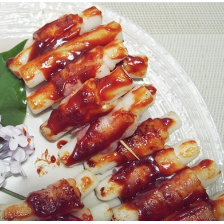

In [ ]:
pic_num = 222
print(target_list[pic_num])
print(image_list[pic_num].shape)
cv2_imshow(image_list[pic_num])


In [ ]:
label_encoder = LabelEncoder()
encoded_target_list = label_encoder.fit_transform(target_list)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(image_list, encoded_target_list, test_size=0.2, random_state=42)
# 정규화
X_train = X_train / 255.0
X_test = X_test / 255.0

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((240, 224, 224, 3), (60, 224, 224, 3), (240,), (60,))

In [ ]:
def VGG16(input_shape):
# VGG16 모델
  model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64,(3,3),strides=(1, 1),activation='relu',padding='same', input_shape=input_shape),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(128,(3,3),strides=(1, 1) ,padding='same',activation='relu'),
    tf.keras.layers.Conv2D(128,(3,3),strides=(1, 1) ,padding='same',activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(256,(3,3),strides=(1, 1),padding='same', activation='relu'),
    tf.keras.layers.Conv2D(256,(3,3),strides=(1, 1),padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(512,(3,3),strides=(1, 1),padding='same', activation='relu'),
    tf.keras.layers.Conv2D(512,(3,3),strides=(1, 1),padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),


    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
  ])

  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  return model

In [ ]:
model = VGG16(input_shape = (224,224,3))
history = model.fit(X_train,y_train,epochs = 100,validation_split = 0.2)

Epoch 1/100
6/6 [==============================] - 33s 5s/step - loss: 6.4615 - accuracy: 0.2969 - val_loss: 1.0997 - val_accuracy: 0.2708
Epoch 2/100
6/6 [==============================] - 30s 5s/step - loss: 1.1005 - accuracy: 0.2708 - val_loss: 1.0995 - val_accuracy: 0.2708
Epoch 3/100
6/6 [==============================] - 30s 5s/step - loss: 1.1012 - accuracy: 0.3177 - val_loss: 1.0994 - val_accuracy: 0.3750
Epoch 4/100
6/6 [==============================] - 30s 5s/step - loss: 1.1006 - accuracy: 0.3125 - val_loss: 1.1017 - val_accuracy: 0.2708
Epoch 5/100
6/6 [==============================] - 30s 5s/step - loss: 1.0986 - accuracy: 0.3385 - val_loss: 1.1007 - val_accuracy: 0.2708
Epoch 6/100
6/6 [==============================] - 30s 5s/step - loss: 1.0984 - accuracy: 0.3385 - val_loss: 1.1013 - val_accuracy: 0.2708
Epoch 7/100
6/6 [==============================] - 30s 5s/step - loss: 1.0982 - accuracy: 0.3385 - val_loss: 1.1009 - val_accuracy: 0.2708
Epoch 8/100
6/6 [==========